# INTRO
This notebook will walk you through how to preprocess and apply machine learning on a big dataset(128GB).
The dataset includes user churn data on an audio streaming application, Sparkify. For the sake of reducing runtime
we will use only a small partition of the dataset(128MB), however the same code can be applied for the full dataset(128GB).

## IMPORTS

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
# get spark session parameters
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1663352941491'),
 ('spark.driver.port', '39049'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'd6da1529fd00'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

## Load and Clean Dataset


In [4]:
# load dataset small portion (128MB)
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#Create a function to print the shape of spark dataframe
def sparkShape(dataFrame):
    """
    input : dataframe
    output : shape of dataframe
    
    description : 
    Pyspark doesn't have a shape method
    this function helps to get shape of pyspark dataframe
    """
    
    return (dataFrame.count(), len(dataFrame.columns))

pyspark.sql.dataframe.DataFrame.shape = sparkShape #Assign shape function as shape attribute

In [7]:
df.shape() #now we have a shape attribute

(286500, 18)

In [8]:
df.show(2, truncate=True) #show only 2 rows

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [9]:
#Sort UserIds
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [10]:
#Sort SessionIds
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [11]:
#Exclude userID where its empty
df = df.filter(df["userId"] != "")

In [12]:
#Drop null values in userId and sessionId
df = df.dropna(how='any', subset=["userId", "sessionId"])

In [13]:
print(f"Shape after dropping null values : {df.shape()}")

Shape after dropping null values : (278154, 18)


In [14]:
#Change spark dataframe to pandas dataframe
pandas_df = df.toPandas()
pandas_df.head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Find users who left the application

In [15]:
#Print distinct values in page column
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [16]:
#Users whose cancellation confirmed
df.select(["userId", "lastname", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+---------+--------------------+
|userId| lastname|                page|
+------+---------+--------------------+
|    18|  Mendoza|Cancellation Conf...|
|    32|    Mckee|Cancellation Conf...|
|   125|     Hart|Cancellation Conf...|
|   105|   Garcia|Cancellation Conf...|
|    17|  Johnson|Cancellation Conf...|
|   143| Harrison|Cancellation Conf...|
|   101|    Hogan|Cancellation Conf...|
|   129|     Wang|Cancellation Conf...|
|   121|    Olsen|Cancellation Conf...|
|    51|  Johnson|Cancellation Conf...|
|    87| Robinson|Cancellation Conf...|
|   122|Patterson|Cancellation Conf...|
|    12|    Perry|Cancellation Conf...|
|    58|   Brooks|Cancellation Conf...|
|    73|   Bailey|Cancellation Conf...|
|     3|  Wheeler|Cancellation Conf...|
|   106|      Key|Cancellation Conf...|
|   103|  Nielsen|Cancellation Conf...|
|    28|  Roberts|Cancellation Conf...|
|    54|   Warren|Cancellation Conf...|
+------+---------+--------------------+
only showing top 20 rows



In [17]:
#Count of users left(churn)
users_churn_true = df.select(["userId", "lastname", "page"]).where(df.page == "Cancellation Confirmation").count()
print(f"Number of users churn positive : {users_churn_true}")

Number of users churn positive : 52


In [18]:
#Create Churn Column
cancellation_confirmed = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", cancellation_confirmed("page"))

In [19]:
#Show users with churn is True
df.select(["lastname", "churn"]).where(df.churn == 1).show()

+---------+-----+
| lastname|churn|
+---------+-----+
|  Mendoza|    1|
|    Mckee|    1|
|     Hart|    1|
|   Garcia|    1|
|  Johnson|    1|
| Harrison|    1|
|    Hogan|    1|
|     Wang|    1|
|    Olsen|    1|
|  Johnson|    1|
| Robinson|    1|
|Patterson|    1|
|    Perry|    1|
|   Brooks|    1|
|   Bailey|    1|
|  Wheeler|    1|
|      Key|    1|
|  Nielsen|    1|
|  Roberts|    1|
|   Warren|    1|
+---------+-----+
only showing top 20 rows



In [20]:
#Create SQL Window Function sort by time
window_function = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [21]:
#Create column with churn sums over window function
df = df.withColumn("churn", Fsum("churn").over(window_function))

In [22]:
#Groupby churn
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [23]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



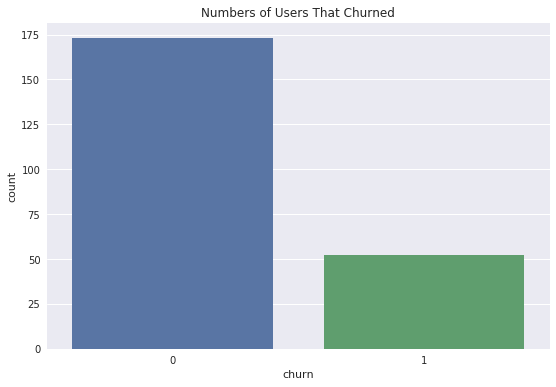

In [24]:
#Plot User Churn Counts

#Switch to Pandas dataframe
pandas_churn = df_churn.toPandas()

#BoxPlot
plt.figure(figsize=(9,6))
sns.barplot(data=pandas_churn, x='churn', y='count')
plt.title("Numbers of Users That Churned")
plt.show()

In [25]:
#Check length not null values
df.filter("length IS NOT NULL").select("length").show()

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
|208.29995|
|260.46649|
|185.44281|
|134.47791|
| 229.8771|
|223.58159|
|201.06404|
|246.69995|
|168.64608|
| 166.1122|
|222.22322|
|229.77261|
|283.74159|
|223.92118|
|250.93179|
+---------+
only showing top 20 rows



In [26]:
#Number of nulll values in length column
df.filter("length IS NULL").select("length").count()

50046

In [27]:
#Create a function to plot the churn distribution
def plot_churn_distribution(df, churn=0):
    """
    Description : Plots the frequency of churn length
    
    Input  : Takes dataframe and churn value 0 or 1
    
    Output : Plots the churn distribution
    """
    
    df_churn = df.filter(df.churn == churn)
    pandas_df = df_churn.toPandas()
    pandas_df.length.dropna(inplace=True)
    bin_bounds = np.arange(10, pandas_df.length.max()+25, 25)
    
    plt.hist(data=pandas_df, x='length', bins=bin_bounds)
    plt.title(f"Churn : {churn}")
    plt.xlim(0, 800)
    plt.xlabel("Duration of Customer")
    plt.ylabel("Freq")
    plt.show()

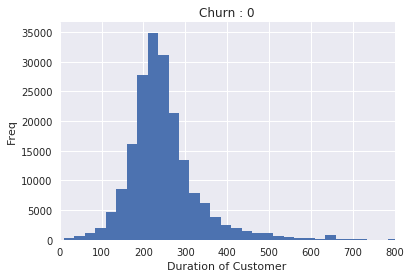

In [28]:
#Plot distribution churn=0
plot_churn_distribution(df, churn=0)

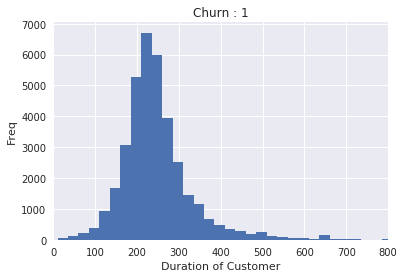

In [29]:
#Plot distribution churn=1
plot_churn_distribution(df, churn=1)

## Plotting Gender Churn Count

In [30]:
#GENDER
#Create Gender DataFrame Grouped by Churn
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [31]:
#Switch to pandas dataframe
df_gender = df_gender.toPandas()
#sort values Descending
df_gender = df_gender.sort_values('count', ascending = False)

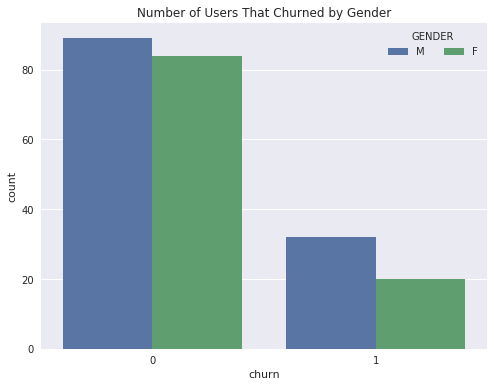

In [32]:
#Create Barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_gender, x='churn', y='count', hue='gender')
ax.legend(loc=1, ncol=2, framealpha=1, title='GENDER')
plt.title("Number of Users That Churned by Gender");

## Plotting Level Churn Count

In [33]:
#LEVEL
#Create Level Dataframe
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [34]:
#Switch to Pandas Dataframe
df_level = df_level.toPandas()

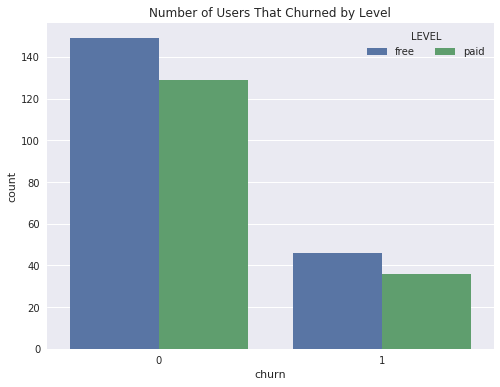

In [35]:
#Plot the barplot using seaborn
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_level, x='churn', y='count', hue='level')
ax.legend(loc=1, ncol=2, framealpha =1, title='LEVEL')
plt.title("Number of Users That Churned by Level");

## Plotting Churn Count by Page

In [36]:
#Pages churn
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

#Switch to Pandas DataFrame
df_page = df_page.toPandas()

#Create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [37]:
#Calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

In [38]:
#Show first 25
df_page.head(25)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


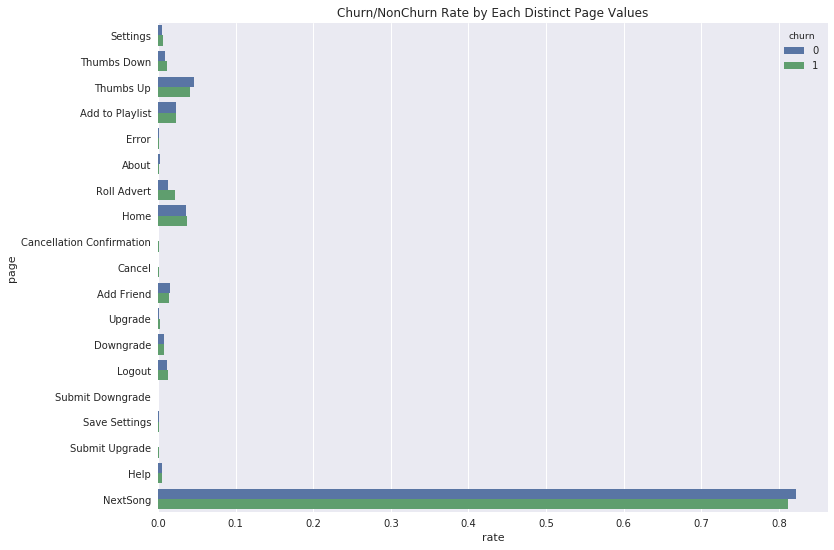

In [41]:
#Create Barplot
plt.figure(figsize=(12,9))
sns.barplot(data=df_page, x='rate', y='page', hue='churn')
plt.title('Churn/NonChurn Rate by Each Distinct Page Values');

## Calculate Songs Per Hour

In [42]:
#Convert TimeStamp to Hours
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

#Create hour column
df = df.withColumn("hour", get_hour(df.ts))

#Show 2
df.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='18')]

In [43]:
#Count of Songs listened per hour by user who did not Churn (Churn==0)
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [44]:
#Show all hours
songs_in_hour_stay.show(50)

+----+-----+
|hour|count|
+----+-----+
|   0| 7527|
|   1| 7035|
|   2| 7014|
|   3| 7063|
|   4| 6914|
|   5| 6960|
|   6| 6836|
|   7| 6873|
|   8| 7023|
|   9| 7268|
|  10| 7502|
|  11| 7440|
|  12| 7918|
|  13| 8073|
|  14| 8792|
|  15| 9462|
|  16| 9721|
|  17| 9464|
|  18| 9146|
|  19| 9112|
|  20| 9107|
|  21| 8853|
|  22| 8526|
|  23| 8085|
+----+-----+



In [45]:
#Switch to Pandas DataFrame
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

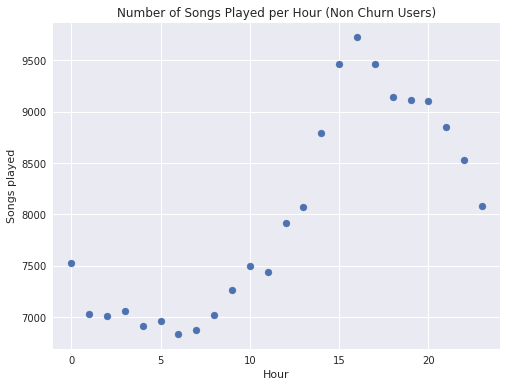

In [46]:
#Plot the distribution Churn==0
plt.figure(figsize=(8,6))
x_val = songs_in_hour_stay_pd["hour"]
y_val = songs_in_hour_stay_pd["count"]
plt.scatter(x_val, y_val)
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour (Non Churn Users)");

In [47]:
#Count of Songs listened per hour by user who did Churn (Churn==1)
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [48]:
#Show all
songs_in_hour_churned.show(50)

+----+-----+
|hour|count|
+----+-----+
|   0| 1535|
|   1| 1353|
|   2| 1322|
|   3| 1292|
|   4| 1233|
|   5| 1218|
|   6| 1218|
|   7| 1218|
|   8| 1230|
|   9| 1230|
|  10| 1380|
|  11| 1390|
|  12| 1408|
|  13| 1571|
|  14| 1702|
|  15| 1892|
|  16| 1915|
|  17| 1996|
|  18| 1978|
|  19| 1818|
|  20| 1749|
|  21| 1605|
|  22| 1596|
|  23| 1545|
+----+-----+



In [49]:
#Switch to Pandas DataFrame
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

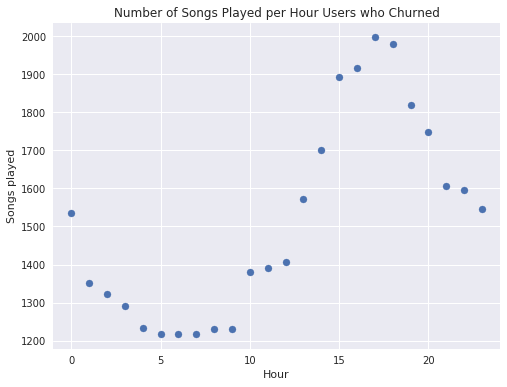

In [50]:
#Plot the distribution Churn==1
plt.figure(figsize=(8,6))
x_val = songs_in_hour_churned["hour"]
y_val = songs_in_hour_churned["count"]
plt.scatter(x_val, y_val)
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

In [51]:
#Songs per session churned/not churned
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()
#Get average grouped by churn
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



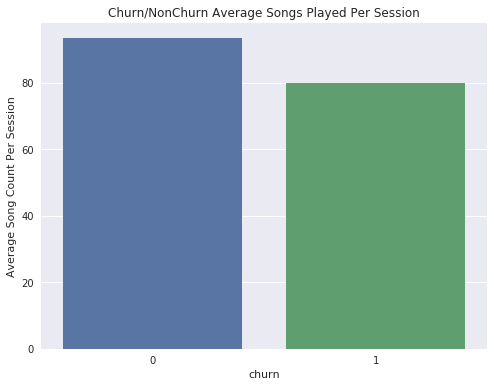

In [52]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})
#Convert this to pandas df
df_songs = df_songs.toPandas()
#Barplot
plt.figure(figsize=(8,6))
ax = sns.barplot(data=df_songs, x='churn', y='avg(count)')
plt.title("Churn/NonChurn Average Songs Played Per Session")
plt.ylabel("Average Song Count Per Session");

## Plot Number Of Unique Artists Listened by Users

In [53]:
#Number of unique artists listened by churn/non-churn
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()
#Get averages
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



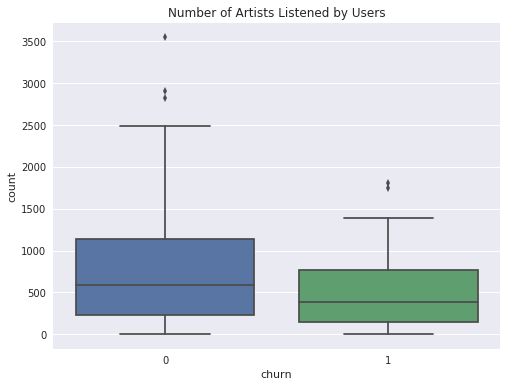

In [54]:
#Switch to Pandas DataFrame
df_artists = df_artists.toPandas()
#Plot boxplot
plt.figure(figsize=(8,6))
ax = sns.boxplot(data=df_artists, x='churn', y='count')
plt.title("Number of Artists Listened by Users")
plt.show()

## User Count Grouped By Location

In [55]:
#LOCATION
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
+--------------------+-----+
only showing top 20 rows



In [56]:
#Retrieve State
get_state = udf(lambda x: x[-2:])

#Create State Column
df_state = df.withColumn("state", get_state(df.location))

#Print State
df_state.select(["location", "state"]).take(2)

[Row(location='Bakersfield, CA', state='CA'),
 Row(location='Boston-Cambridge-Newton, MA-NH', state='NH')]

In [57]:
#Create State DataFrame
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()
#Switch to Pandas DataFrame
pandas_state = df_state.toPandas()

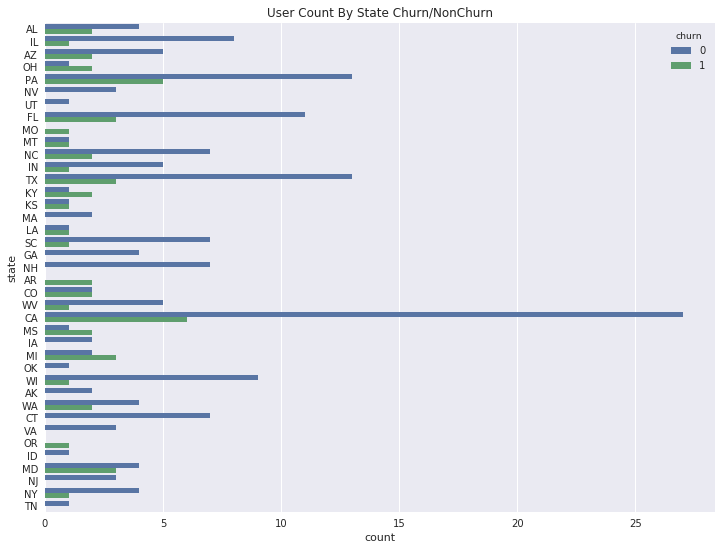

In [58]:
#Plot Users Per State
plt.figure(figsize=(12,9))
sns.barplot(data=pandas_state, x='count', y='state', hue='churn')
plt.title('User Count By State Churn/NonChurn')
plt.show()

## User Count Grouped By Operating System

In [59]:
#Operating Systems
df_op = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])
#Switch to Pandas
pandas_op = df_op.toPandas()

In [60]:
#Print Unique Values (Op System)
pandas_op.userAgent.unique()

array([ '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
       '"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D167 Safari/9537.53"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
       'Mozilla/5.0 (Windows NT 6.1; rv:31.0) Gecko/20100101 Firefox/31.0',
       'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
       '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"',
       'Mozilla/5.0 (Win

In [61]:
#List of Operating Systems
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]
#Create os column
pandas_op['os'] = pandas_op.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [62]:
pandas_op.os.value_counts()

Windows    111
Mac         86
iPhone      13
Linux       12
iPad         3
Name: os, dtype: int64

In [63]:
#Get Indexes
os_order = pandas_op.os.value_counts().index

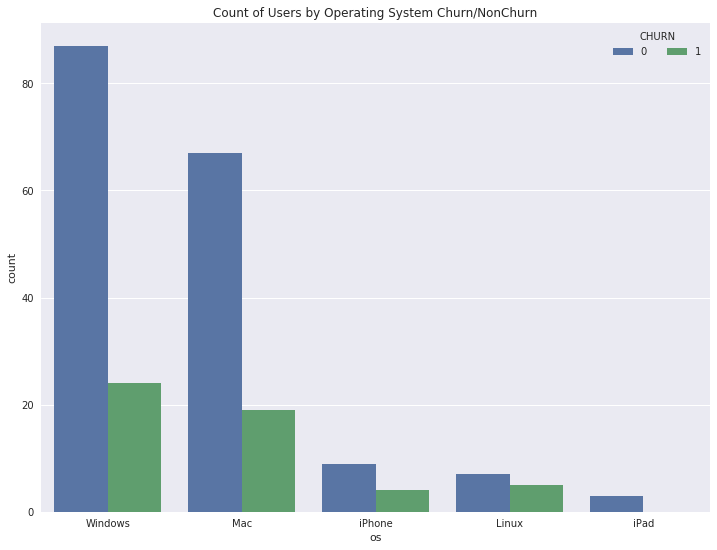

In [64]:
# plot count for churn and non churn users
plt.figure(figsize=(12,9))
sns.countplot(data=pandas_op, x='os', hue='churn', order=os_order)
plt.title('Count of Users by Operating System Churn/NonChurn')
plt.legend(loc=1, ncol=2, framealpha=1, title='CHURN')
plt.show()

In [65]:
#List of browsers
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

#Create browser column
pandas_op['browser'] = pandas_op.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

#Replace Trident With Internet Explorer
pandas_op['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)

#Print unique values
pandas_op.browser.value_counts()

Chrome               117
Firefox               50
Safari                46
Internet Explorer     12
Name: browser, dtype: int64

In [66]:
#Get Indexes
browser_order = pandas_op.browser.value_counts().index

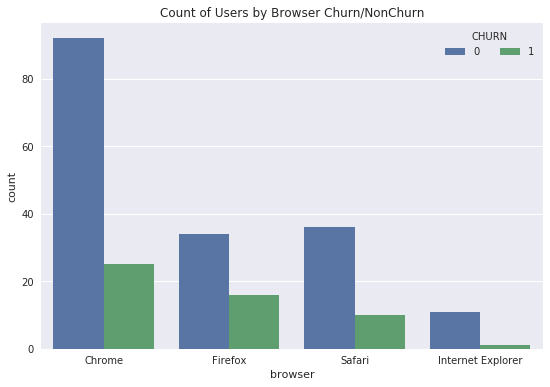

In [67]:
#Countplot
plt.figure(figsize=(9,6))
sns.countplot(data=pandas_op, x='browser', hue='churn', order=browser_order)
plt.title('Count of Users by Browser Churn/NonChurn')
plt.legend(loc=1, ncol=2, framealpha=1, title='CHURN')
plt.show()

## Calculate Days Since Registered

In [68]:
#Create Days DataFrame
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [69]:
#SQL Window Function
window_function = Window.partitionBy("userId").orderBy(desc("ts"))

#Create Rank Column
df_days = df_days.withColumn("Rank", dense_rank().over(window_function))

#Show DataFrame
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [70]:
#Filter those with a rank of 1 i.e the first rows
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

#Show DataFrame
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [71]:
#Substract TimeStamp from Registration Time
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

#Create Days Column 
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

#Show DataFrame
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

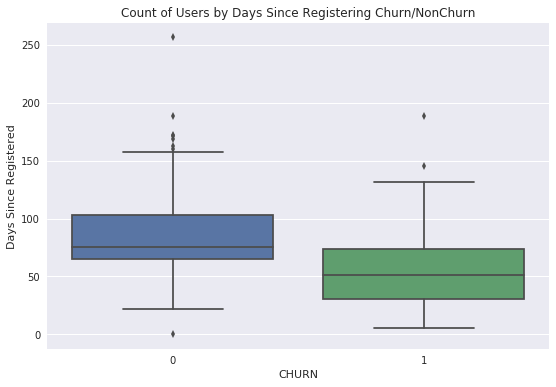

In [72]:
#Switch to Pandas DataFrame
pandas_days = df_days.toPandas()

#BoxPlot for Days Column
plt.figure(figsize=(9,6))
sns.boxplot(data=pandas_days, x='churn', y='days')
plt.title('Count of Users by Days Since Registering Churn/NonChurn')
plt.ylabel("Days Since Registered")
plt.xlabel("CHURN")
plt.show()

# Feature Engineering

In this part we will be performing Feature Engineering in order to get the important features for model training preparation.
We will extract 2 categorical, 8 numerical in total 10 features.
Namely;
    * Gender
    * Level
    * Average Number of Songs per Session
    * Number of Rollads
    * Count of ThumbsDown
    * Count of ThumbsUp
    * Number of Friends
    * Number of Songs Added
    * Count of Distinct Artists
    * Days Since Registered
    
After extracting these features one by one later we will join them into single spark DataFrame.
Finally we will add Label Column.

## Gender Feature

In [73]:
#Create Gender DataFrame
feature_gender = df.select(['userId', 'gender']).dropDuplicates()

#Assign 0 or 1, 1 if Female, 0 if Male
feature_gender = feature_gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

print(f"Feature Gender Shape : {feature_gender.shape()}")

#Show DataFrame
feature_gender.show(5)

Feature Gender Shape : (225, 2)
+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



## Level Feature

In [74]:
#Select UserId Level and Ts sorted by UserId
df_level = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')

#Create SQL Window Function
window_userid = Window.partitionBy("userId").orderBy(desc("ts"))

#Create Rank Column
df_level = df_level.withColumn("Rank", dense_rank().over(window_userid))

df_level.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [75]:
#Filter only Rank==1
feature_level = df_level.filter(df_level.Rank == 1).drop(df_level.Rank)

#Drop TS
feature_level = feature_level.drop('ts')

#Turn Categorical to Numerical
feature_level = feature_level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))

print(f"Feature Level Shape : {feature_level.shape()}")

#Show 5
feature_level.show(5)

Feature Level Shape : (225, 2)
+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



## Average Number of Songs Per Session

In [76]:
#Filter where page==NextSong and groupby userid session id
feature_songs = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

feature_songs = feature_songs.groupby('userid').agg({"count":"avg"})

#Rename Avg Count column
feature_songs = feature_songs.withColumnRenamed("avg(count)", "avg_song_count")

print("Feature Songs Shape : {feature_songs.shape()}")

#Show 5
feature_songs.show(5)

Feature Songs Shape : {feature_songs.shape()}
+------+------------------+
|userid|    avg_song_count|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



## Number of RollAds

In [77]:
#Select Userid and Page
feature_rollads = df.select(["userId", "page"])

#Define Function to assign numerical values
udf_rollads = udf(lambda x: 1 if x=="Roll Advert" else 0, IntegerType())

feature_rollads = feature_rollads.withColumn("rollad", udf_rollads("page"))

feature_rollads = feature_rollads.groupby("userId").sum("rollad")

#Rename Column
feature_rollads = feature_rollads.withColumnRenamed("sum(rollad)", "rollad_count")

print(f"Feature Rollads Shape : {feature_rollads.shape()}")

feature_rollads.show(5)

Feature Rollads Shape : (225, 2)
+------+------------+
|userId|rollad_count|
+------+------------+
|100010|          52|
|200002|           7|
|   125|           1|
|    51|           0|
|   124|           4|
+------+------------+
only showing top 5 rows



## Count of Thumbs Down

In [78]:
#Select UserId and Page
feature_thumbsdown = df.select(["userId", "page"])

#UDF to switch numerical vals
udf_thumbsdown = udf(lambda x: 1 if x=="Thumbs Down" else 0, IntegerType())

feature_thumbsdown = feature_thumbsdown.withColumn("thumbsdown", udf_thumbsdown("page"))

feature_thumbsdown = feature_thumbsdown.groupby("userId").sum("thumbsdown")

#Rename Column
feature_thumbsdown = feature_thumbsdown.withColumnRenamed("sum(thumbsdown)", "thumbsdown_count")

print(f"Feature ThumbsDown Shape : {feature_thumbsdown.shape()}")

#Show 5
feature_thumbsdown.show(5)

Feature ThumbsDown Shape : (225, 2)
+------+----------------+
|userId|thumbsdown_count|
+------+----------------+
|100010|               5|
|200002|               6|
|   125|               0|
|    51|              21|
|   124|              41|
+------+----------------+
only showing top 5 rows



## Count of Thumbs Up

In [79]:
#Select UserId and Page
feature_thumbsup = df.select(["userId", "page"])

#UDF to switch numerical vals
udf_thumbsup = udf(lambda x: 1 if x=="Thumbs Up" else 0, IntegerType())

feature_thumbsup = feature_thumbsup.withColumn("thumbsup", udf_thumbsup("page"))

feature_thumbsup = feature_thumbsup.groupby("userId").sum("thumbsup")

#Rename Column
feature_thumbsup = feature_thumbsup.withColumnRenamed("sum(thumbsup)", "thumbsup_count")

print(f"Feature ThumbsUp Shape : {feature_thumbsup.shape()}")

#Show 5
feature_thumbsup.show(5)

Feature ThumbsUp Shape : (225, 2)
+------+--------------+
|userId|thumbsup_count|
+------+--------------+
|100010|            17|
|200002|            21|
|   125|             0|
|    51|           100|
|   124|           171|
+------+--------------+
only showing top 5 rows



## Number of Friends

In [80]:
#Select UserId and Page
feature_friends = df.select(["userId", "page"])

#UDF for categorical to numerical
udf_friends = udf(lambda x: 1 if x=="Add Friend" else 0, IntegerType())

#Apply UDF
feature_friends = feature_friends.withColumn("friends_count", udf_friends("page"))

feature_friends = feature_friends.groupby("userId").sum("friends_count")

#Rename Column
feature_friends = feature_friends.withColumnRenamed("sum(friends_count)", "friends_Count")

print(f"Feature Friends Shape : {feature_friends.shape()}")

#Show 5
feature_friends.show(5)

Feature Friends Shape : (225, 2)
+------+-------------+
|userId|friends_Count|
+------+-------------+
|100010|            4|
|200002|            4|
|   125|            0|
|    51|           28|
|   124|           74|
+------+-------------+
only showing top 5 rows



## Number of Songs Added

In [81]:
#Select UserId and Page
feature_songs_added = df.select(["userId", "page"])

#Udf for songs added
udf_songs_added = udf(lambda x: 1 if x=="Add to Playlist" else 0, IntegerType())

feature_songs_added = feature_songs_added.withColumn("songs_added", udf_songs_added("page"))

feature_songs_added = feature_songs_added.groupby("userId").sum("songs_added")

#Rename Column
feature_songs_added = feature_songs_added.withColumnRenamed("sum(songs_added)", "songs_added")

print(f"Feature Songs Added Shape : {feature_songs_added.shape()}")

#Show 5
feature_songs_added.show(5)

Feature Songs Added Shape : (225, 2)
+------+-----------+
|userId|songs_added|
+------+-----------+
|100010|          7|
|200002|          8|
|   125|          0|
|    51|         52|
|   124|        118|
+------+-----------+
only showing top 5 rows



## Count of Distinct Artists

In [82]:
#Select Userid And artists grouped by UserId
feature_artists = df.select(["userId", "artist"]).dropDuplicates().groupby("userId").count()

#Rename COlumn
feature_artists = feature_artists.withColumnRenamed("count", "artists_count")

print(f"Feature Artists Shape : {feature_artists.shape()}")

#Show 5
feature_artists.show(5)

Feature Artists Shape : (225, 2)
+------+-------------+
|userId|artists_count|
+------+-------------+
|100010|          253|
|200002|          340|
|   125|            9|
|    51|         1386|
|   124|         2233|
+------+-------------+
only showing top 5 rows



## Days Since Registered

In [83]:
#Drop unnecessary Columns that we previously created df_days
feature_registered_days = df_days.drop("registration", "ts", "churn", "delta_days")

print(f"Feature Registered Days Shape : {feature_registered_days.shape()}")

#Show 5
feature_registered_days.show(5)

Feature Registered Days Shape : (225, 2)
+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



## Create Labels

In [84]:
#Create Churn Label
label = df.select(["userId", "churn"]).dropDuplicates().groupby("userId", "churn").count()

#Drop count
label = label.drop("count")

#Rename column
label = label.withColumnRenamed("churn", "label")

print(f"Label Shape : {label.shape()}")

#Show 5
label.show(5)

Label Shape : (225, 2)
+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



## Combine All Feature DataFrames into Single DataFrame

In [85]:
#Join Feature to create one df from all feature

features = feature_artists.join(feature_friends, ["userId"])\
    .join(feature_gender, ["userId"]).join(feature_level, ["userId"])\
    .join(feature_registered_days, ["userId"]).join(feature_rollads, ["userId"])\
    .join(feature_songs, ["userId"]).join(feature_songs_added, ["userId"])\
    .join(feature_thumbsdown, ["userId"]).join(feature_thumbsup, ["userId"])\
    .join(label, ["userId"])

#Drop userid
features = features.drop("userId") 

In [86]:
#Show 5
features.show(5)

+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+
|artists_count|friends_Count|gender|level|              days|rollad_count|    avg_song_count|songs_added|thumbsdown_count|thumbsup_count|label|
+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+
|          253|            4|     1|    0|  55.6436574074074|          52|39.285714285714285|          7|               5|            17|    0|
|          340|            4|     0|    1| 70.07462962962963|           7|              64.5|          8|               6|            21|    0|
|            9|            0|     0|    0| 71.31688657407408|           1|               8.0|          0|               0|             0|    1|
|         2233|           74|     1|    1|131.55591435185184|           4|145.67857142857142|        118|              41|           171

## Vectorized Columns into Single Column with Vector Assembler

In [87]:
#Input Columns
inputcols = ["artists_count", "friends_Count", "gender", "level", "days",
             "rollad_count", "avg_song_count", "songs_added", "thumbsdown_count", "thumbsup_count"]

#Output Column
outputcol = "vector_features"

#Instantiate Vector Assembler
assembler = VectorAssembler(inputCols=inputcols, outputCol=outputcol)

#Transform Assembler
features = assembler.transform(features)

#Show 5
features.show(5)

+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+--------------------+
|artists_count|friends_Count|gender|level|              days|rollad_count|    avg_song_count|songs_added|thumbsdown_count|thumbsup_count|label|     vector_features|
+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+--------------------+
|          253|            4|     1|    0|  55.6436574074074|          52|39.285714285714285|          7|               5|            17|    0|[253.0,4.0,1.0,0....|
|          340|            4|     0|    1| 70.07462962962963|           7|              64.5|          8|               6|            21|    0|[340.0,4.0,0.0,1....|
|            9|            0|     0|    0| 71.31688657407408|           1|               8.0|          0|               0|             0|    1|(10,[0,4,5,6],[9....|
|         

## Standardization with StandardScaler

In [88]:
#Instantiate Scaler
scaler = StandardScaler(inputCol="vector_features", outputCol="features", withStd=True)

#Fit Scaler
scaler_fit = scaler.fit(features)

#Transform Scaler
features = scaler_fit.transform(features)

#Show 5
features.show(5)

+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+--------------------+--------------------+
|artists_count|friends_Count|gender|level|              days|rollad_count|    avg_song_count|songs_added|thumbsdown_count|thumbsup_count|label|     vector_features|            features|
+-------------+-------------+------+-----+------------------+------------+------------------+-----------+----------------+--------------+-----+--------------------+--------------------+
|          253|            4|     1|    0|  55.6436574074074|          52|39.285714285714285|          7|               5|            17|    0|[253.0,4.0,1.0,0....|[0.41890401101713...|
|          340|            4|     0|    1| 70.07462962962963|           7|              64.5|          8|               6|            21|    0|[340.0,4.0,0.0,1....|[0.56295400690050...|
|            9|            0|     0|    0| 71.31688657407408|         

**We used StandardScaler, since our values are in different scale than each other. In order to create a proper model, the values should have 0 mean and standard deviation of 1. It will help algorithm to learn easily.**

# Modeling

Now that we have our features dataset, we are ready to train our models.

The problem is a classification problem therefor we will use classification algorithms in order to predict churns

<br /> We will use 3 different classification algorithms.

    - LogisticRegression
    - RandomForestClassifier
    - GBTClassifier(Gradient Boosted Tree)

## Logistic Regression

Logistric Regression is one of the most common machine learning algorithm. It is used to calculate probability of a binary event. In this case the event is whether user churn or not. It is easy to implement and train the model.

## Random Forest Classifier

Random Forest is a powerfull machine learning algorithm that is used for classification problems. It is an augmented version of Decision Trees. Using multiple decision trees it avoids overfitting and gives more robust and accurate results for unseen data.
For imbalanced datasets Random Forest is widely used.

## Gradient Boosted Tree Classifier (GBT)

Gradient-boosted decision trees are a popular method for solving prediction problems in both classification and regression domains. In our problem we will utilize the GBT in classification problem. The approach improves the learning process by simplifying the objective and reducing the number of iterations to get to a sufficiently optimal solution.


**Steps we follow to train our models ;**

- Instantiate the model
- Train the model on training dataset
- Predicting the churn on test dataset
- Evaluating the model accuracy


## Metrics

To evaluate our model's performance we will be using F1 score.


The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. It is primarily used to compare the performance of two classifiers. Suppose that classifier A has a higher recall, and classifier B has higher precision. In this case, the F1-scores for both the classifiers can be used to determine which one produces better results. F1 is also better for dealing with imbalanced classes like we have here.


After we pick the best model using F1 Score, we will tune the model with hyperparameters.


## Train Test Validation Split

At first we should split the features dataset into train, test and validation dataset. Then we can use these different datasets to train and evaluate our models

In [89]:
#Train test split

train, test, valid = features.randomSplit([0.6, 0.2, 0.2], seed=101)

print(f"Training Dataset Shape : {train.shape()}")
print(f"Test Dataset Shape : {test.shape()}")
print(f"Validation Dataset Shape : {valid.shape()}")

Training Dataset Shape : (136, 13)
Test Dataset Shape : (44, 13)
Validation Dataset Shape : (45, 13)


In [90]:
#Instantiate all of our models and include a seed for reproduciblity where possible
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=101)
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=10, seed=101)

#Create model list
model_list = [lr,rf,gbt]

#Model evaluater
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')

In [108]:
#Loop through the models
for model in model_list:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print("------------------------------------------------------\n")
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

------------------------------------------------------

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 113.19812059402466 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.6968888888888889
The accuracy of the LogisticRegression model is: 0.7555555555555555
------------------------------------------------------

RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 174.23125576972961 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.7169486972871342
The accuracy of the RandomForestClassifier model is: 0.7555555555555555
------------------------------------------------------

GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 252.19619846343994 seconds
GBTClassifier predicting started

**Here we can see all of our three models has the same accuracy 0.7555 however the F1 Score is different for each model
The highest F1 score belongs to GBTClassifier even though it took more time train approximately 245 seconds.
On the otherside LogisticRegression has the lowest F1 score, 0.6968, however it almost took as half as GBT to train, 118 seconds. Evem though we can pick RandomForestClassifier as the optimal model since the train time 180 seconds and F1 score 0.7169. This depends on whether we consider performance or cost as priority. Here I will be choosing the GBTClassifier since the dataset is small, however in case of using the full dataset(128GB) we should consider the cost efficient solution RandomForestClassifier.**

## Model Tuning

In [96]:
#Check GBT parameters
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

**Here we can pick maxIter and maxDepth parameters to tune**


We will use crossvalidation to test all parameters. It will take considerable long since we try different combination of parameters. 

In [97]:
#ParameterGrid Builder
paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxIter,[5, 10, 20])\
    .addGrid(gbt.maxDepth,[5, 10])\
    .build()

crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)

In [98]:
#Fit crossvalidation on training dataset - Takes approx. 1.5 hours
%%time
cv_model = crossval.fit(train)

CPU times: user 53.4 s, sys: 15.8 s, total: 1min 9s
Wall time: 1h 29min 8s


In [99]:
cv_model.avgMetrics

[0.6538264576742332,
 0.6794265667535704,
 0.6726046729904379,
 0.6794265667535704,
 0.6514737064958948,
 0.6794265667535704]

In [100]:
#Test on validation dataset
results = cv_model.transform(valid)

In [101]:
#Print Accuracy
accuracy = results.filter(results.label == results.prediction).count() / (results.count())
print(accuracy)

0.7777777777777778


In [102]:
#Get the best model
best_model = cv_model.bestModel

In [103]:
#Print maxiter and maxdepth parameters of the best model
print(f"Best Param (MaxIter): {best_model._java_obj.getMaxIter()}")
print("----------------------------")
print(f"Best Param (MaxDepth): {best_model._java_obj.getMaxDepth()}")

Best Param (MaxIter): 5
----------------------------
Best Param (MaxDepth): 10


In [104]:
#Print F1 and Accuracy for the best model
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print("----------------------------")
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

F1 for our best model is: 0.7585641025641026
----------------------------
Accuracy for our best model is: 0.7555555555555555


## Plot Feature Importances

In [105]:
#Retrieve feature importances
importances = best_model.featureImportances

x_values = list(range(len(importances)))

features_list = ["artists_count", "friends_Count", "gender", "level", "days", "rollad_count", "avg_song_count", "songs_added", "thumbsdown_count", "thumbsup_count"]

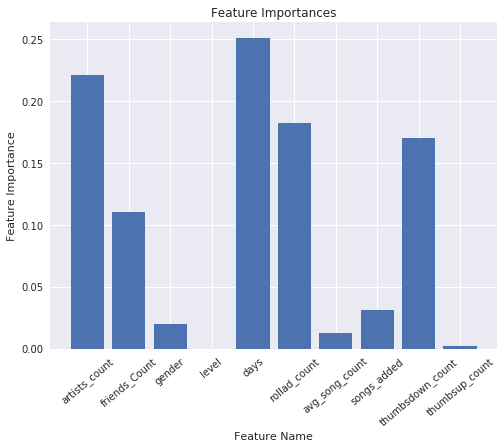

In [107]:
plt.figure(figsize=(8,6))
plt.bar(x_values, importances, orientation='vertical')
plt.xticks(x_values, features_list, rotation=40)
plt.ylabel('Feature Importance')
plt.xlabel('Feature Name')
plt.title('Feature Importances')
plt.show()

**Here we can see the most important features are days, artists_count, rollad_count, thumbsdown_count.**
**That means they have more impact compared to other features when they go up or down**

## Summary

* Firstly we explored our dataset by applying various summary statistics and visulizations

* Later we did some data wrangling to preprocess the data

* Afterwards we used feature engineering in order to extract required features for our modelling

* We joined all the features into single dataframe and added label column, at this stage the dataset is ready to train

* Trained 3 different machine learning classification algorithms namely, LogisticRegression, RandomForest, GBTClassifier

* Picked our best model as GBTClassifier and did further model tuning using cross validation

* As best model we used GBTClassifier with maxIter=5 and maxDepth=10

* Finally we reported the F1 score as 0.7585641025641026 and Accuracy as 0.7555555555


## Sources

[Udacity PySpark Course](https://learn.udacity.com/nanodegrees/nd025/parts/cd2242/lessons/40daa501-5409-457d-ab00-31eeec728f74/concepts/ffc25c76-0c87-43a1-a083-74e303f1a6c5)

https://sparkbyexamples.com/pyspark/pyspark-when-otherwise/

https://sparkbyexamples.com/spark/spark-dataframe-where-filter/

https://sparkbyexamples.com/spark/using-groupby-on-dataframe/

https://sparkbyexamples.com/spark/spark-sql-udf/

https://sparkbyexamples.com/spark/spark-sql-sort-functions/

https://sparkbyexamples.com/spark/spark-sql-window-functions/

https://sparkbyexamples.com/spark/spark-sql-aggregate-functions/

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.tree.RandomForest.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.GBTClassifier.html

https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html

https://www.sparkitecture.io/machine-learning/model-evaluation



